- なんかよくわからないバグが残っている
- 総和がEに比例して増えるが，なぜか1/2*Eくらい？

In [60]:
!pip install japanize-matplotlib nptyping &>/dev/null && wait $PID # pyplot用日本語フォント，Numpy用型ヒント
from matplotlib import pylab as plt
import japanize_matplotlib

import numpy as np
import pandas as pd

from pprint import pprint as pprint
from typing import Callable, List, Dict, Any
from nptyping import NDArray, Float

def loadData():
    #Googleコミュニティーモビリティーレポートはソースと同じフォルダ以下のMobility_Report/2021_JP_Region_Mobility_Report.csvとして置いてある
    #from google.colab import drive
    #drive.mount('/content/drive')
    url='/content/drive/MyDrive/Colab Notebooks/Mobility_Report/2021_JP_Region_Mobility_Report.csv'
    #url='https://doc-08-1g-docs.googleusercontent.com/docs/securesc/81b058k2d9ftb1keg1t2m33g6apjn1t6/j8p0igduj3vjcnksb5a64hp7lj2gavb9/1624034250000/06840078231200536082/06840078231200536082/16B7BvJ4TeuSSGmFEFrEIoKdiuUAmlzpE?e=download&authuser=0&nonce=f9s9rhh3k943u&user=06840078231200536082&hash=q43mre9u3fjmr71gg1huus8c7l4ec7th'
    #df=pd.read_csv(url, index_col=8, usecols=['date','retail_and_recreation_percent_change_from_baseline'], parse_dates=[8])
    df=pd.read_csv(url)
    df=df[df['sub_region_1'].str.contains('Tokyo',na=False)]
    val=df.residential_percent_change_from_baseline.values

    val=np.convolve(val, np.ones(7,dtype=np.float64), mode='same')#移動平均
    val=np.log10(val)
    val=(val-np.average(val))/(np.std(val)*3)+1.0

    print("df.shape",df.shape)
    return val.tolist()[0:-3]

In [27]:
GROUPS=["0-9","10-19","20-29","30-39","40-40","50-59","60-69","70-79","80-89","90-99","100-"]
VARIANTS=["N501Y"]
Matrix=NDArray[(len(GROUPS),len(VARIANTS)),Float[64]]

class PopulationVariable:
    def __init__(self, name, init_values: Matrix,
                target_and_output_funcs: Dict[Any,List[Callable[[Any],Matrix]]]=None,
                init_d_values: Matrix=None,
                output_funcs_self=None) -> None:
        self.name=name
        self.values=[init_values.astype(np.float64)]
        self.target_and_output_funcs=target_and_output_funcs
        self.output_funcs_self=output_funcs_self
        if(init_d_values is not None):
            self.d=[init_d_values.astype(np.float64)]
        else:
            self.d=[np.zeros_like(init_values, dtype=np.float64)]
        self.input=[np.zeros_like(init_values, dtype=np.float64)]
        self.out=[np.zeros_like(init_values, dtype=np.float64)]
        self.correction=[np.zeros_like(init_values, dtype=np.float64)]

        self.values.append(np.copy(self.values[-1]))
        self.d.append(np.zeros_like(self.d[-1]))
        self.out.append(np.zeros_like(self.out[-1]))
        self.input.append(np.zeros_like(self.input[-1]))
        self.correction.append(np.zeros_like(self.correction[-1]))


    # 入力を受け入れて，values[t]に足す
    def add_inflow(self, t, value: Float[64])->None:
        #print(self.name+".add_inflow",t,np.sum(value))
        value=value.astype(np.float64)
        self.values[t]+=value
        self.d[t]+=value
        self.input[t]+=value
    
    # valuesとdの先頭を追加する．
    # あらかじめtarget_and_output_funcsに登録されている各targetごとの
    # 1) 出力関数fを呼び，targetごとの流出量を計算
    # 2) target.add_inflow()で出力する
    # 3) 流出量合計をself.valuesとself.dから引く
    def flush(self, t):
        #print(self.name+".flush",t)

        if(self.target_and_output_funcs is not None):
            o={}
            for target, f in self.target_and_output_funcs.items():
                o[target]=f(self, self.output_funcs_self, self.values[t-1], t)
                
                #print(self.name+"→"+target.name+".add_inflow",t,np.sum(o[target]))
                target.add_inflow(t, o[target])
                self.values[t]-=o[target]
                self.d[t]-=o[target]
                self.out[t]+=o[target]

            # 負の値が出たときに補正する(その年齢層のみ)
            if(True):
                is_negative=(self.values[t]<=0)
                is_zero=(np.array(self.values[t]==0) & np.array(self.d[t]==0))
                is_negative=is_negative & (~is_zero)
                if(np.any(is_negative)):
                    self.correction[t]=np.copy(self.values[t])
                    self.d[t][is_negative]=-self.values[t][is_negative]
                    self.values[t][is_negative]=0.0
                    self.correction[t]=self.correction[t]-self.values[t]

                    #print(self.name+"→ sum correction["+str(t)+"]=",self.correction[t])
                    for target, f in self.target_and_output_funcs.items():
                        #print(self.name+"→"+target.name+" correction["+str(t)+"]=",self.correction[t]*np.sum(o[target])/np.sum([np.sum(vs) for vs in o.values()]))
                        if(np.sum([vs for vs in o.values()])!=0):
                            #print("Corr. "+self.name+"→"+target.name+".add_inflow",t,np.sum(self.correction[t]*np.sum(o[target])/np.sum([np.sum(vs) for vs in o.values()])))
                            target.add_inflow(t, self.correction[t]*np.sum(o[target])/np.sum([np.sum(vs) for vs in o.values()]))
                        else:
                            #print("Corr. "+self.name+"→"+target.name+".add_inflow",t,np.sum(self.correction[t]))
                            target.add_inflow(t, self.correction[t])
        # init
        self.values.append(np.copy(self.values[t]))
        self.d.append(np.zeros_like(self.d[t], dtype=np.float))
        self.out.append(np.zeros_like(self.d[t], dtype=np.float))
        self.input.append(np.zeros_like(self.d[t], dtype=np.float))
        self.correction.append(np.zeros_like(self.values[t]))


In [57]:
class Data:
    def __init__(self,label=None,dV0=None,R0=None,mobility=None):
        self.label=label
        self.NUM_OF_DAYS=170
        #self.NUM_OF_DAYS=365
        self.NUM_OF_CALCULATED_DAYS=0
        self.GROUPS=["0-9","10-19","20-29","30-39","40-40","50-59","60-69","70-79","80-89","90-99","100-"]
        
        self.R0=np.array([[1.2]])#1.5--0.9くらいを想定．幅2.4
        if(R0 is not None):
            self.R0=R0
        #1.32倍（95％信頼区間1.28-1.37）https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/10279-covid19-40.html
        #0.94 (95%信頼区間 0.90-0.97)，1.23 (95%信頼区間 1.18-1.28)

        #東京都の人口
        #https://www.bousai.metro.tokyo.lg.jp/_res/projects/default_project/_page_/001/013/860/47kai/2021052704.pdf
        self.N:Matrix=np.array([[524939+499632], # 0-9
                    [493559+566729], # 10-19
                    [753698+863678], # 20-29
                    [969877+1038390], # 30
                    [1154214+1048170], # 40
                    [891332+722755], # 50
                    [725312+854575], # 60
                    [713342+583971], # 70
                    [449314+261441], # 80
                    [108999+28732], # 90
                    [5142]], dtype=np.float)# >=100
        #ゼロベクトル
        self.ZERO=np.zeros_like(self.N, dtype=np.float64)
        #1ベクトル
        self.ONE=self.ZERO+1.0

        if(mobility is not None):
            self.mobility=mobility
            print("R範囲=avg-3σ〜avg+3σ=",self.R0*(np.average(gmobility)-np.std(gmobility)*3),"〜",self.R0*(np.average(gmobility)+np.std(gmobility)*3))
            print("np.average(mobility)=",np.average(self.mobility))
            print("np.std(mobility)*3=",np.std(self.mobility)*3)

            if(self.NUM_OF_DAYS>len(mobility)):
                self.mobility=self.mobility+([self.mobility[-1]]*(self.NUM_OF_DAYS-len(mobility)))
        else:
            self.mobility=[1.0]*(self.NUM_OF_DAYS+1)
        print("len(self.mobility)=",len(self.mobility))
        print("self.NUM_OF_DAYS=",self.NUM_OF_DAYS)

        self.I0:Matrix=np.array([
                    [8], # 0-19
                    [5], # 0-19
                    [30], # 20-
                    [20], # 30-
                    [17], # 40-
                    [12], # 50-
                    [5], # 60-
                    [3], # 70-
                    [1], # 80-
                    [1], # 90-
                    [0]], dtype=np.float)# >=100
        self.I0=self.I0/np.sum(self.I0)*766.4 #5/7時点陽性者
        # 都道府県名,日付,入院中,軽症・中等症,重症,宿泊療養,自宅療養,調整中
        # 東京都,2021-05-07,2265,2196,69,1152,2157,1271

        self.Q0=np.copy(self.I0)/np.sum(self.I0)*4500 #5/7時点全患者

        # 罹患率10万人あたり https://datastudio.google.com/u/0/reporting/c1dfbd03-0aa7-457d-81d2-3ca5be34706b/page/KNtNB?s=mM99TXFS68A
        # 「同性同世代10万人あたり何人感染しているか。……かかりやすさを比較」
        self.ALPHA=np.array([[413.05+399.74], # 0-9
                        [871.69+749.47], # 10-19
                        [2551.66+2330.63], # 20-29
                        [1821.6+1268.86], # 30
                        [1336.05+842.52], # 40
                        [1249.87+922.23], # 50
                        [945.98+655.33], # 60
                        [748.8+566.84], # 70
                        [952.52+804.37], # 80
                        [1393.54+1336.56], # 90
                        [2597.4+1582.82]], dtype=np.float)# >=100
        self.ALPHA=self.ALPHA/np.sum(self.ALPHA)
        
        #治癒率(I→R，Q→R)
        #self.GAMMA=self.ALPHA*(0.178881340543816720383164524)
        self.GAMMA=self.ALPHA*(1-0.1**(1/10))# #(1-GAMMA)^10=0.2 ⇒ GAMMA=1-0.2^(1/10)．順調な8割は10日目までに排菌が止まり，1割はCに残留する

        #隔離率 I→Q
        self.EPSILON=self.ZERO+0.151657 #I*(1-EPSILON)^10=0.1*I #完治までに10%が隔離されない
        #self.EPSILON=self.ZERO+1/10 #平均10日で発見・隔離される
        #self.EPSILON=self.ZERO+1/1000

        #発症率 E→I
        self.DELTA=self.ZERO+(1/5.6)
        
        #重症化率
        self.KAPPA=np.array([
                    [0.5], # <10
                    [0.2], # 10-19
                    [0.3], # 20-29
                    [1], # 30
                    [4], # 40
                    [10], # 50
                    [25], # 60
                    [47], # 70
                    [71], # 80
                    [78], # 90
                    [78]], dtype=np.float)# >=100
        self.KAPPA=self.KAPPA/sum(self.KAPPA)*0.06617624
        #ちなみに大阪5/23-以降の全年齢の重症化率K(t)=dC(t)/I(t-1)=0.06617624
        #重症化しない率(1-p)から: (1-p)/p=5.6, 重症化率p=0.151515

        #重症化後退院率．
        #self.LAMBDA=np.copy(self.ZERO)+(1-0.5**(1/14)) #(1-LAMBDA)^14=0.1 ⇒ LAMBDA=1-0.5^(1/14) 14日で1/10になる
        self.LAMBDA=1/self.KAPPA
        self.LAMBDA=self.KAPPA/np.sum(self.KAPPA)*(1-0.0001**(1/14))

        #感染率(R0=β/γ⇒β=R0γ．Iの減少要因の平均をγの代わりに利用する)
        self.BETA=self.R0*self.GAMMA/self.N #BETA=R0*GAMMA/N (R0の定義より．αは年齢別の係数)

        # Nに対するワクチン接種割合(速度)[-/day]．Nと同じ形の行列np.array()で年齢別に設定．
        self.OMEGA=np.array([[0], # <10
                    [0], # 10-19
                    [1], # 20-29
                    [1], # 30
                    [1], # 40
                    [1], # 50
                    [1], # 60
                    [1], # 70
                    [1], # 80
                    [1], # 90
                    [1]], dtype=np.float64)# >=100
        self.OMEGA=self.OMEGA*self.N #Nの割合
        if(0<np.sum(self.OMEGA)):
            self.OMEGA=self.OMEGA/np.sum(self.OMEGA)
        self.OMEGA=self.OMEGA*((0.37/100)*np.sum(self.N)) #%/day
        #self.OMEGA=self.OMEGA*(1/100)*np.sum(self.N) #1%/day
        #print("self.OMEGA init=",self.OMEGA)
        
        if(dV0 is not None):
            self.OMEGA=dV0
            #print("dV0 is not None: dV0=",dV0)
        self.dV=[np.copy(self.OMEGA)]

        #print("self.dV init=",self.dV[0])

        def StoV(self, self_orig, s: Matrix, t)->Matrix:
            self_orig.dV.append(self_orig.dV[t-1])

            #Sがマイナスになりそうな世代のdV[t]を0に．傾きを維持する
            is_neg_vec=(s-self_orig.dV[t]<0)
            if(np.any(is_neg_vec)):
                self_orig.dV[t][is_neg_vec]=s[is_neg_vec]
                if(0<np.sum(self_orig.dV[t])):
                    #print("分数:self_orig.dV[t]/np.sum(self_orig.dV[t])*np.sum(self_orig.dV[0])",self_orig.dV[t]/np.sum(self_orig.dV[t])*np.sum(self_orig.dV[0]))
                    self_orig.dV[t]=self_orig.dV[t]/np.sum(self_orig.dV[t])*np.sum(self_orig.dV[0])
            if(False and t<10):
                print("t",t)
                print("np.sum(s)=",t,np.sum(s))
                print("np.sum(v)=",t,np.sum(self_orig.V.values[t-1]))
                print("np.sum(dv)=",t,np.sum(self_orig.dV[t]))
                print("dv=",t,self_orig.dV[t])
            return np.copy(self_orig.dV[t])

        def StoE(self, self_orig, s: Matrix, t)->Matrix:
            #print("Rt=sum(s*self_orig.BETA*self_orig.mobility[t])=",np.sum(s*self_orig.BETA*self_orig.mobility[t]))
            return self_orig.BETA*self_orig.mobility[t]*np.sum(self_orig.I.values[t-1])*s

        def EtoI(self, self_orig, e: Matrix, t)->Matrix:
            self_orig.positives.append(self_orig.DELTA*e)
            return self_orig.DELTA*e

        def ItoR(self, self_orig, i: Matrix, t)->Matrix:
            return self_orig.GAMMA*i
        
        def ItoC(self, self_orig, i: Matrix, t)->Matrix:
            return self_orig.KAPPA*i

        def ItoQ(self, self_orig, i: Matrix, t)->Matrix:
            return self_orig.EPSILON*i
        
        def CtoR(self, self_orig, c: Matrix, t)->Matrix:
            return self_orig.LAMBDA*c

        def QtoC(self, self_orig, q: Matrix, t)->Matrix:
            return self_orig.KAPPA*q

        def QtoR(self, self_orig, q: Matrix, t)->Matrix:
            return self_orig.GAMMA*q

        self.positives=[np.copy(self.ZERO)] #newly quarantined

        self.V=PopulationVariable('V',np.copy(self.ZERO), {}, init_d_values=self.dV[0]) #→出口なし
        self.R=PopulationVariable('R',np.copy(self.ZERO), {}) #→出口なし
        self.C=PopulationVariable('C',np.copy(self.ZERO),
                                  {self.R:CtoR},output_funcs_self=self) #critical(severe)
        self.Q=PopulationVariable('Q',np.copy(self.Q0),
                                  {self.C:QtoC, self. R:QtoR}, output_funcs_self=self) #quarantined
        self.I=PopulationVariable('I',450*np.copy(self.ALPHA),
                                  {self.R:ItoR, self.C:ItoC, self.Q:ItoQ},output_funcs_self=self)
        self.E=PopulationVariable('E',50*np.copy(self.ALPHA),
                                  {self.I:EtoI},output_funcs_self=self)
        self.S=PopulationVariable('S',np.copy(self.N),
                                  {self.E:StoE, self.V:StoV},output_funcs_self=self)

        self.pipeline=[self.S,self.E,self.I,self.Q,self.C,self.R,self.V]
        self.before=[self.S,]
        self.patient=[self.E,self.I,self.Q,self.C]
        self.after=[self.R,self.V]
        
        print("label",self.label)
        #print("N=",self.N)
        print("np.sum(N)=",np.sum(self.N))
        print("γ=",self.GAMMA)
        print("np.sum(γ)=",np.sum(self.GAMMA))
        print("ε=",self.EPSILON)
        
        #print("α=",self.ALPHA)
        print("sum(α)=",np.sum(self.ALPHA))

        print("β*N=(ε+γ+κ)/3*R0*N=",self.BETA*self.N)
        print("sum(β*N)=",np.sum(self.BETA*self.N/len(self.BETA)))

        print("κ=",self.KAPPA)
        print("(大阪5/23-以降の重症化率K(t)=C(t)/I(t-1)=0.06617624)\nsum(κ)/len(κ)=",np.sum(self.KAPPA)/len(self.KAPPA))
        print("重症化後退院率λ=",self.LAMBDA)

        print("dV=",self.V.d)
        print("sum(dV[0])=",sum(self.V.d))
        print("validation sum(self.V.d)/sum(N)=1=",np.sum(self.V.d)/np.sum(self.N))

    def calc(self):
        for t in range(1,self.NUM_OF_DAYS):
            for pvar in self.pipeline:
                pvar.flush(t)
            self.NUM_OF_CALCULATED_DAYS=t
        print("NUM_OF_CALCULATED_DAYS: ",self.NUM_OF_CALCULATED_DAYS)
        return self

#data0=Data(label="0.37%/day接種,R0=1",R0=1).calc()
#data1=Data(label="0.37%/day接種,R0=1.32",R0=1.32).calc()
gmobility=loadData()

#gmobilityはnp.average()=1，np.std()=0.25に加工
#R=1.33-0.67(平均1，幅=±σ=±0.333)くらいに誘導する
#R=1.5-0.9(平均1，幅=±3σ=±0.6)くらいに誘導する
if(np.std(gmobility)!=0):
    gmobility=[(m-np.average(gmobility))/(np.std(gmobility)*3)/1.0000000000000002 for m in gmobility]
    gmobility=[m+(np.std(gmobility)*3) for m in gmobility]
print("np.average()=",np.average(gmobility))
print("np.std()*3=",np.std(gmobility)*3)

data2=Data(label="接種なし,R0≃1.5-0.9,gmobility",R0=1.05,
    dV0=np.array([[0], # <10
    [0], # 10-19
    [0], # 20-29
    [0], # 30
    [0], # 40
    [0], # 50
    [0], # 60
    [0], # 70
    [0], # 80
    [0], # 90
    [0]]),# >=100
    mobility=gmobility
    ).calc()

data3=Data(label="接種なし,R0=1.0",R0=1.05,
    dV0=np.array([[0], # <10
    [0], # 10-19
    [0], # 20-29
    [0], # 30
    [0], # 40
    [0], # 50
    [0], # 60
    [0], # 70
    [0], # 80
    [0], # 90
    [0]]),# >=100
    ).calc()

#datas=[data0,data1,data2,data3]
datas=[data2,data3]

df.shape (165, 15)
np.average()= 1.0
np.std()*3= 1.0
R範囲=avg-3σ〜avg+3σ= 0.0 〜 2.1
np.average(mobility)= 1.0
np.std(mobility)*3= 1.0
len(self.mobility)= 170
self.NUM_OF_DAYS= 170
label 接種なし,R0≃1.5-0.9,gmobility
np.sum(N)= 13257801.0
γ= [[0.00634617]
 [0.01265784]
 [0.03812038]
 [0.02412997]
 [0.01701003]
 [0.01695952]
 [0.01250285]
 [0.01027237]
 [0.0137176 ]
 [0.02131632]
 [0.0326387 ]]
np.sum(γ)= 0.2056717652757185
ε= [[0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]]
sum(α)= 1.0
β*N=(ε+γ+κ)/3*R0*N= [[0.00666348]
 [0.01329073]
 [0.0400264 ]
 [0.02533647]
 [0.01786054]
 [0.01780749]
 [0.01312799]
 [0.01078599]
 [0.01440348]
 [0.02238214]
 [0.03427063]]
sum(β*N)= 0.01963230486722768
κ= [[1.05041651e-04]
 [4.20166603e-05]
 [6.30249905e-05]
 [2.10083302e-04]
 [8.40333206e-04]
 [2.10083302e-03]
 [5.25208254e-03]
 [9.87391517e-03]
 [1.49159144e-02]
 [1.63864975e-02]
 [1.63864975e-02]]
(大阪5/23-以降の重症化率K(t)=C(t)/

接種なし,R0≃1.5-0.9,gmobility


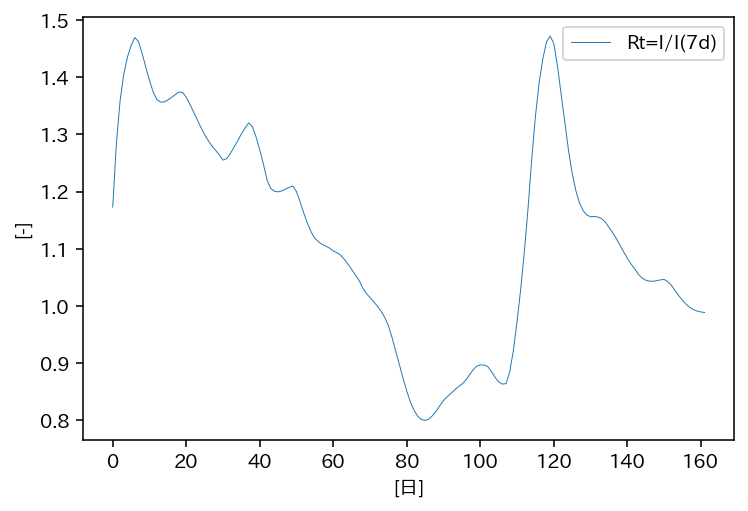

np.average(mobility)= 0.9900432008834369
np.std(mobility)= 0.3284659714130068


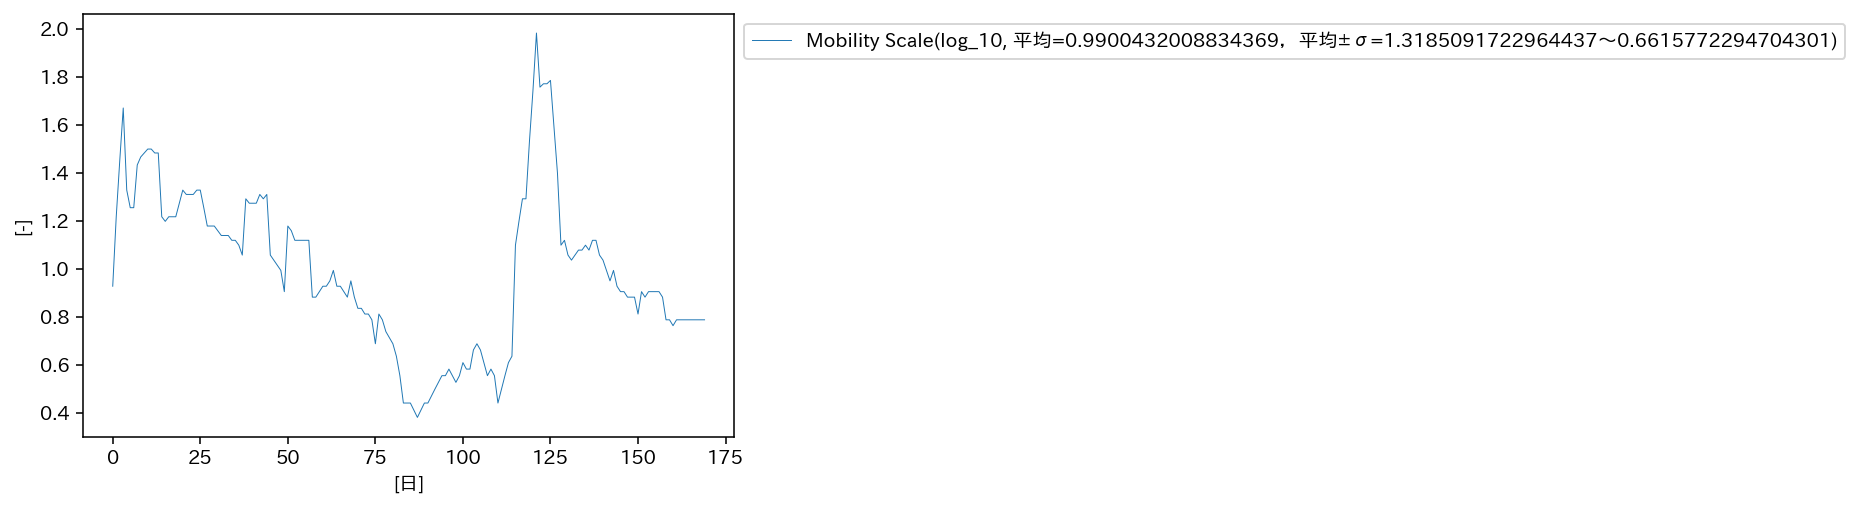

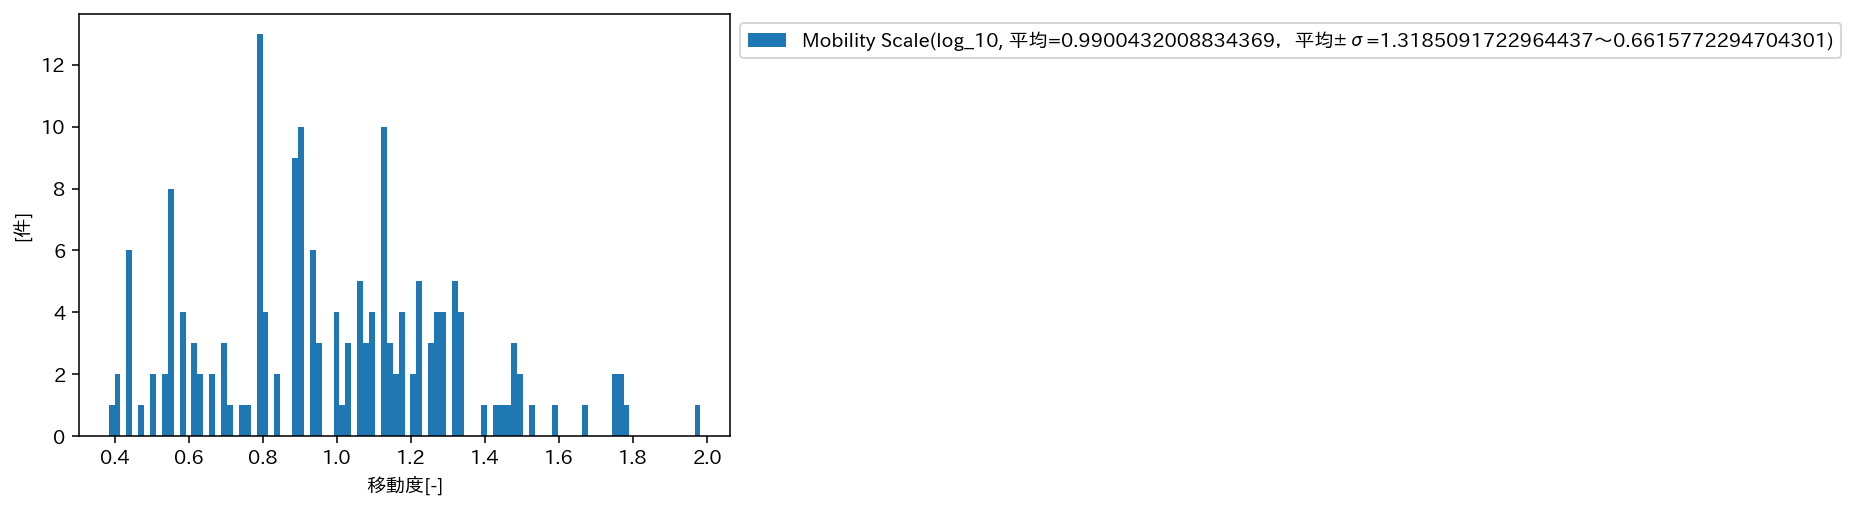

接種なし,R0=1.0


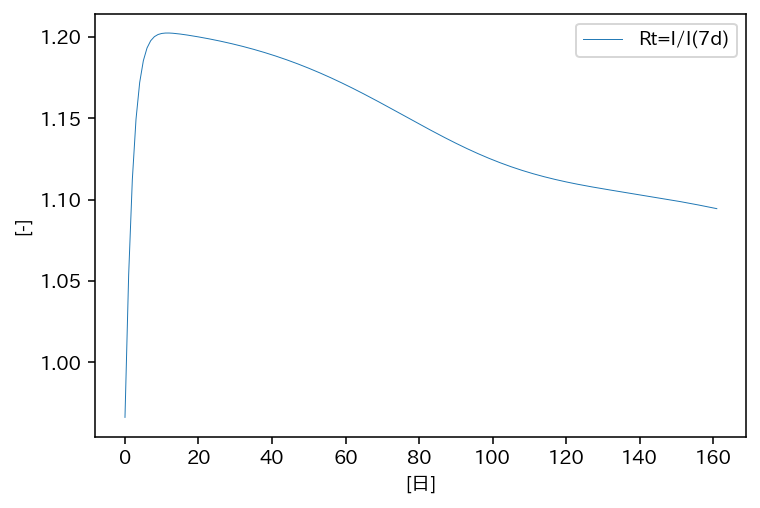

np.average(mobility)= 1.0
np.std(mobility)= 0.0


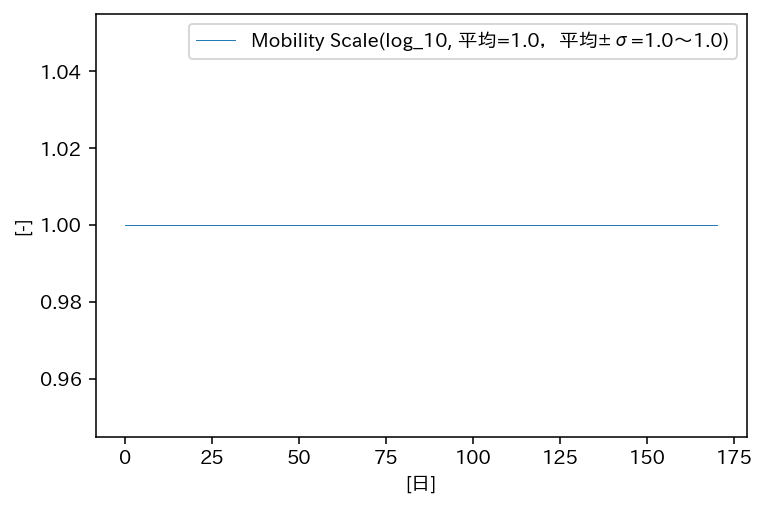

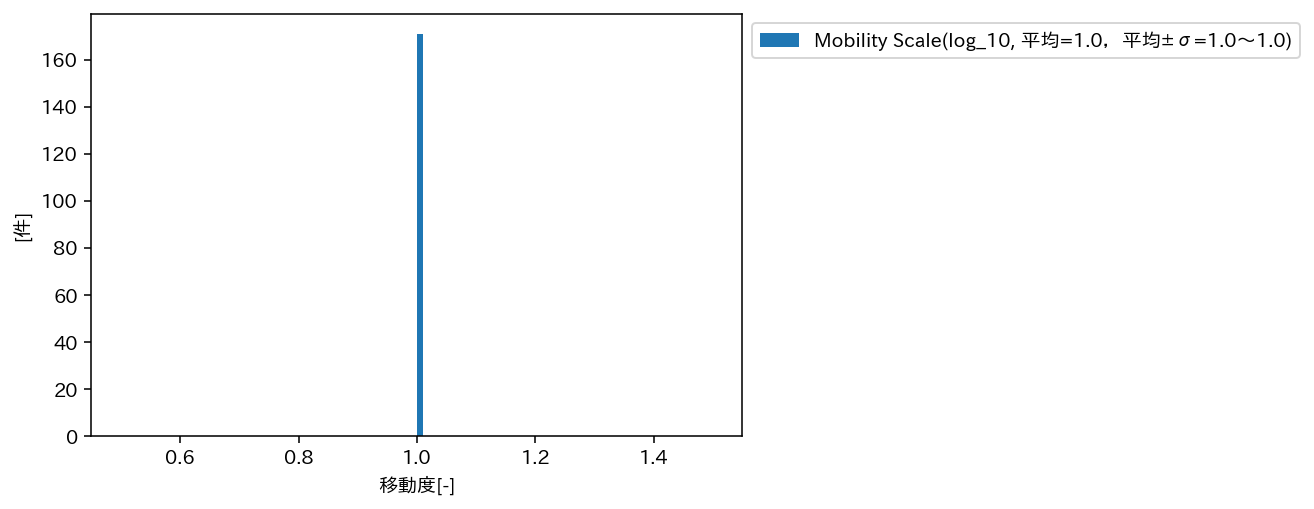

In [55]:
# plot
plt.rcParams["figure.dpi"]=140
def plot2(d):
    N=d.N
    S=d.S.values
    E=d.E.values
    I=d.I.values
    R=d.R.values
    Q=d.Q.values
    C=d.C.values
    V=d.V.values

    positives=d.positives

    all=d.pipeline
    before=d.before
    patient=d.patient
    after=d.after

    dS=d.S.d
    dSin=d.S.input
    dSout=d.S.out
    dI=d.I.d
    dIin=d.I.input
    dIout=d.I.out
    dE=d.E.d
    dEin=d.E.input
    dEout=d.E.out
    dR=d.R.d
    dQ=d.Q.d
    dC=d.C.d
    dCin=d.C.input
    dCout=d.C.out
    dV=d.V.d
    dVin=d.V.input
    dVout=d.V.out

    mobility=d.mobility

    T=range(0,d.NUM_OF_CALCULATED_DAYS+1)

    def print_len():
        print("NUM_OF_DAYS:",d.NUM_OF_DAYS)
        print("NUM_OF_CALCULATED_DAYS:",d.NUM_OF_CALCULATED_DAYS)
        print("len(S)",len(S))
        print("len(I)",len(I))
        print("len(E)",len(E))
        print("len(R)",len(R))
        print("len(Q)",len(Q))
        print("len(C)",len(C))
        print("len(V)",len(V))
        print("len(dV)",len(dV))
        print("sum(S[-1])",sum(S[-1]))
        print("sum(I[-1])",sum(I[-1]))
        print("sum(R[-1])",sum(R[-1]))
        print("sum(Q[-1])",sum(Q[-1]))
        print("sum(C[-1])",sum(C[-1]))
        print("sum(V[-1])",sum(V[-1]))
        print("sum(dV[-1])",sum(dV[-1]))
    #print_len()

    #for k, age in enumerate(GROUPS):
    plt.plot([np.sum(I[t])/np.sum(I[t-8:t-1])*7 for t in range(8,d.NUM_OF_CALCULATED_DAYS+1)], label="Rt=I/I(7d)", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    print("np.average(mobility)=",np.average(mobility))
    print("np.std(mobility)=",np.std(mobility))
    plt.plot(mobility, label="Mobility Scale(log_10, 平均="+str(np.average(mobility))+"，平均±σ="+str(np.average(mobility)+np.std(mobility))+"〜"+str(np.average(mobility)-np.std(mobility))+")", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()


    plt.hist(mobility, bins=100, label="Mobility Scale(log_10, 平均="+str(np.average(mobility))+"，平均±σ="+str(np.average(mobility)+np.std(mobility))+"〜"+str(np.average(mobility)-np.std(mobility))+")")
    plt.xlabel("移動度[-]")
    plt.ylabel("[件]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
print(data2.label)
plot2(data2)
print(data3.label)
plot2(data3)


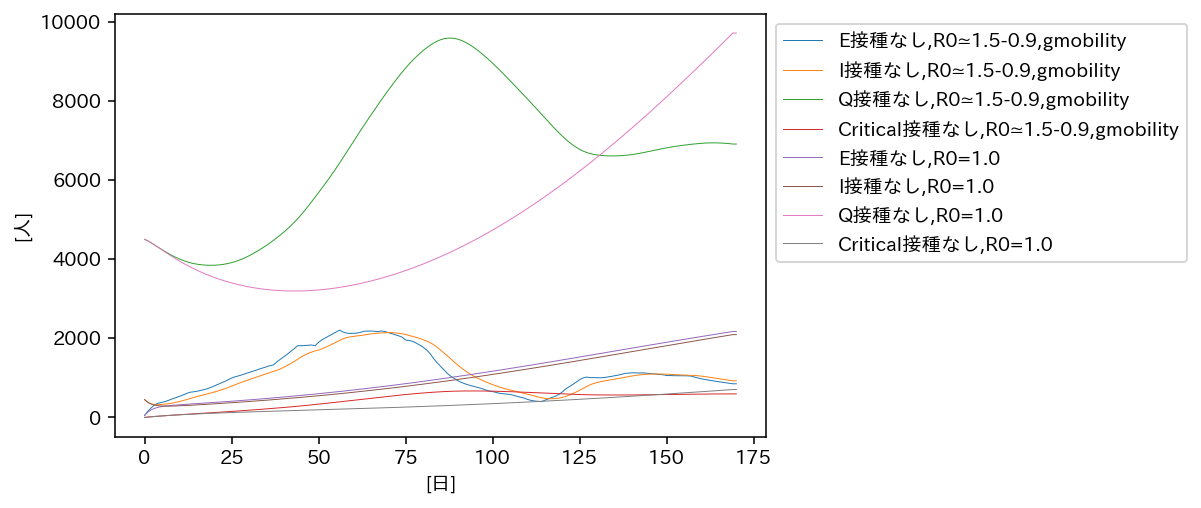

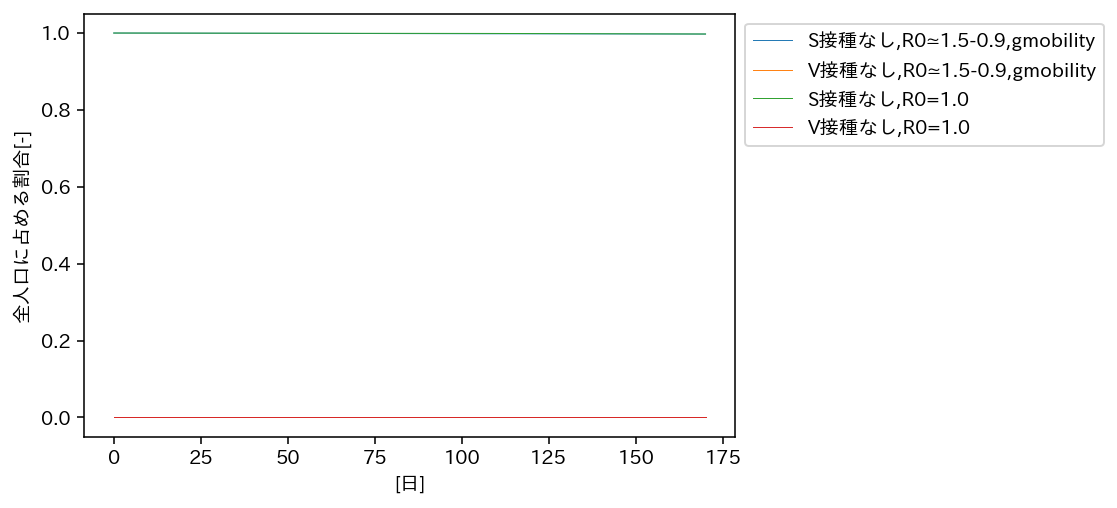

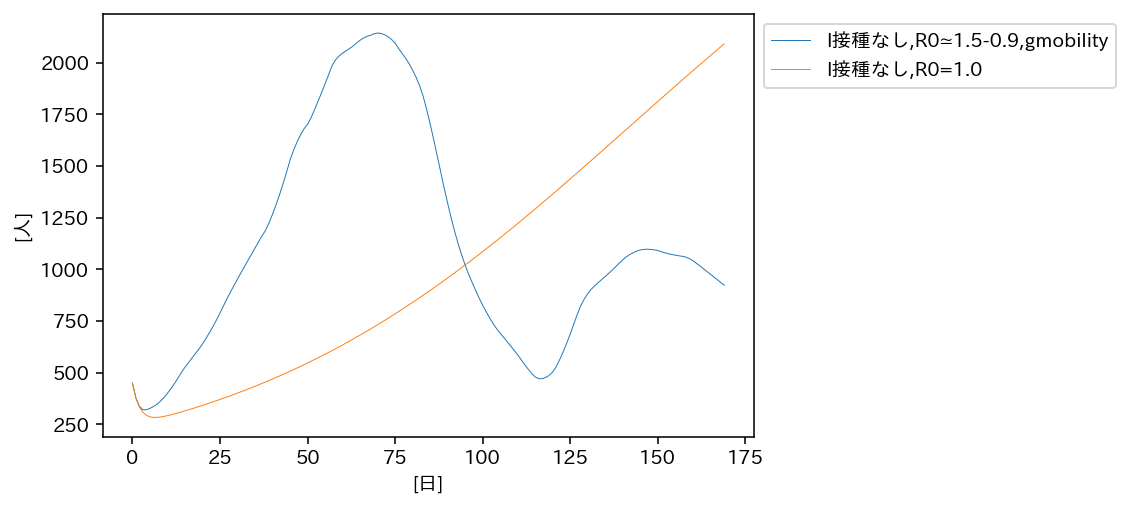

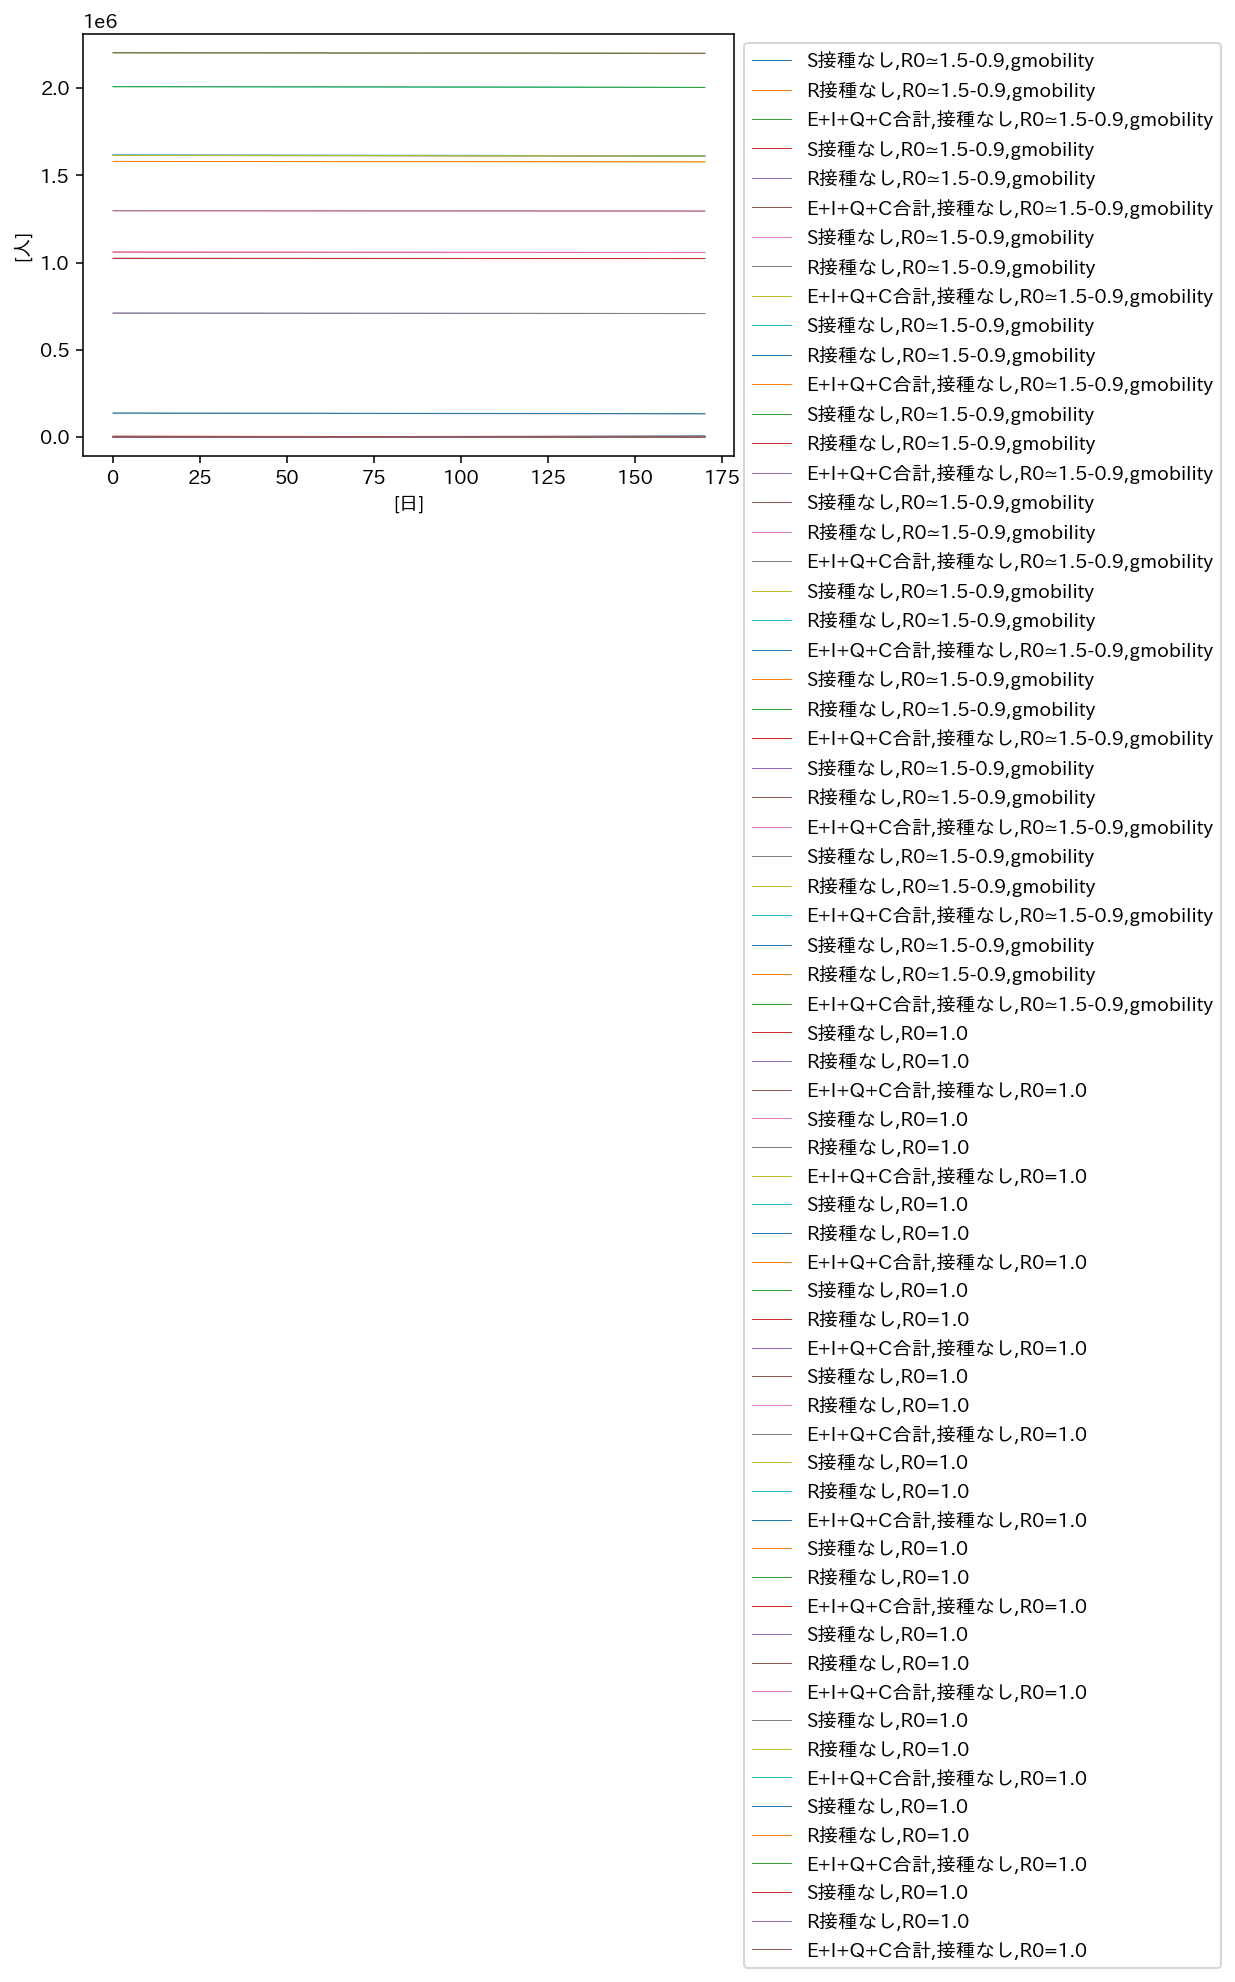

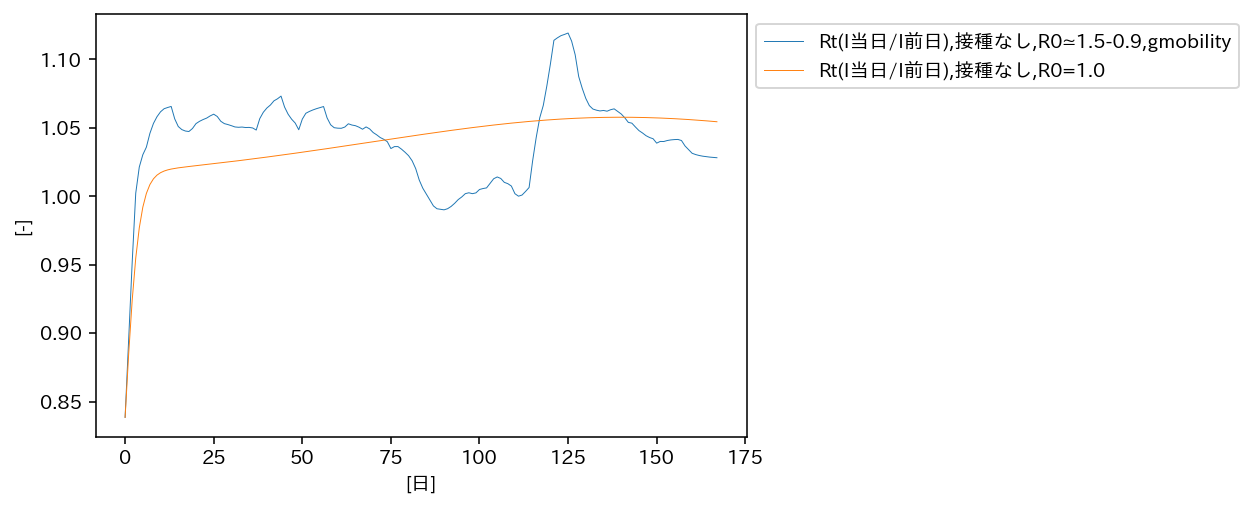

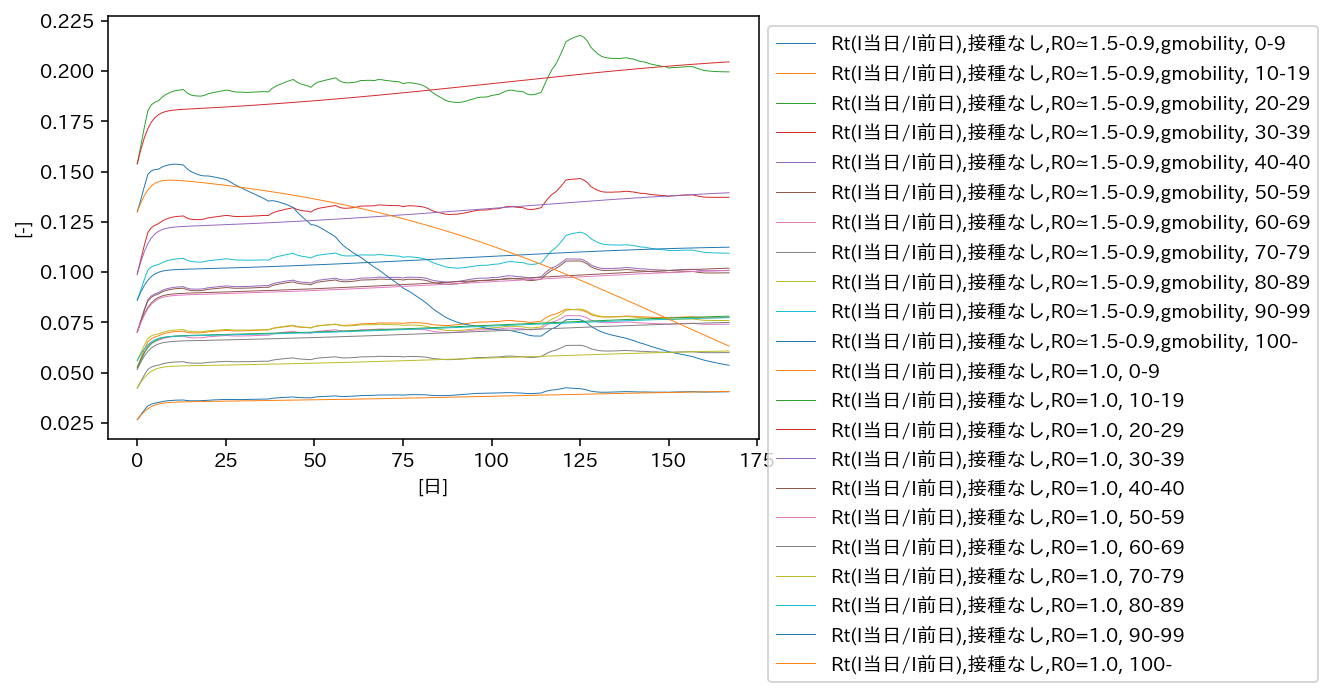

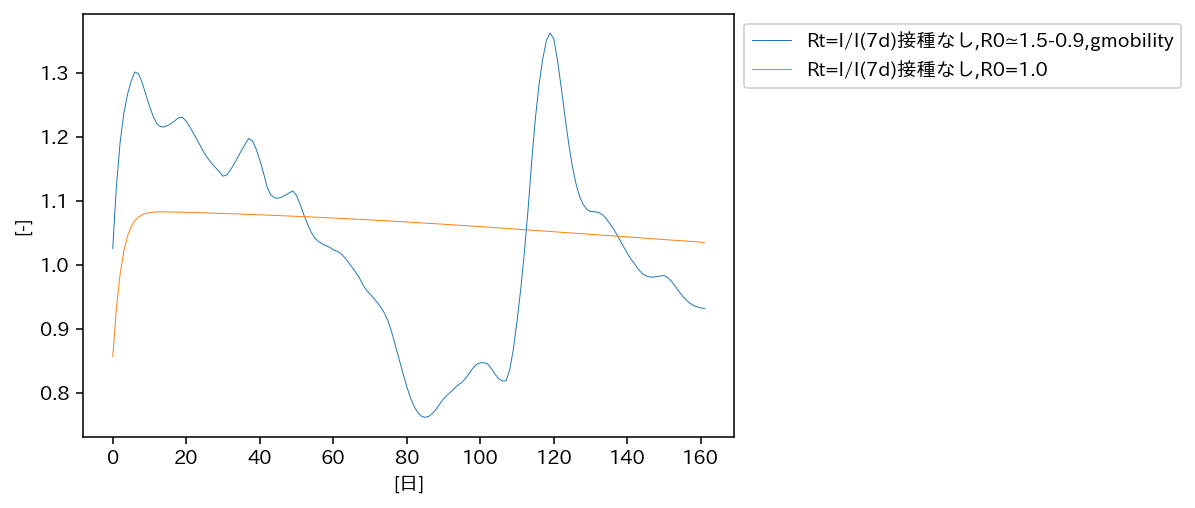

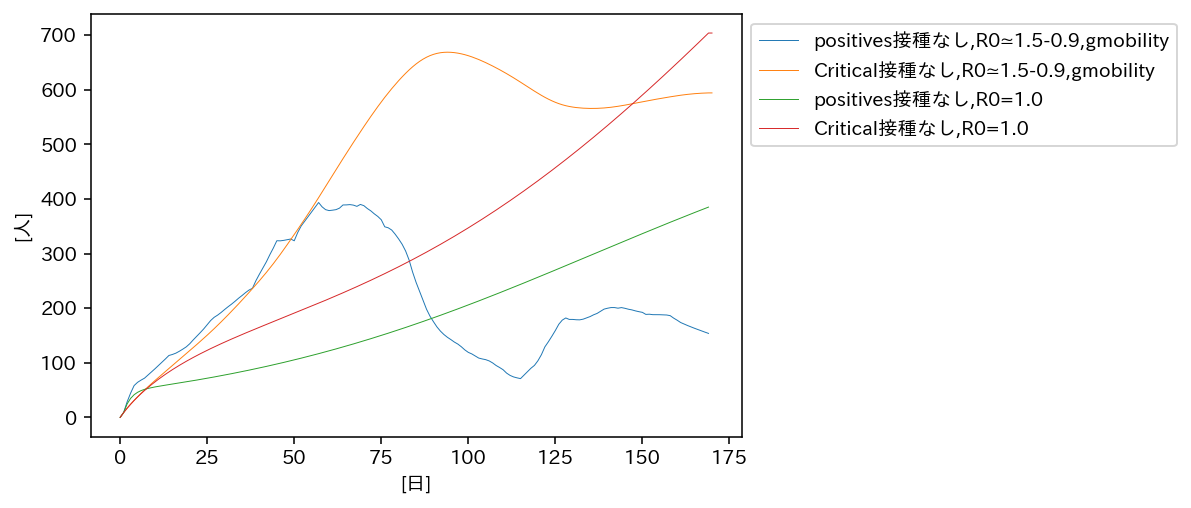

In [58]:
# two data plot
def plotdiff(datas):
    class Localdata:
        pass
    ds=[]
    Ts=[]
    for i, d in enumerate(datas):
        ds.append(Localdata())
        ds[i].S=d.S.values
        ds[i].E=d.E.values
        ds[i].I=d.I.values
        ds[i].R=d.R.values
        ds[i].Q=d.Q.values
        ds[i].C=d.C.values
        ds[i].V=d.V.values
        ds[i].positives=d.positives
        ds[i].dV=d.V.d
        ds[i].dI=d.I.d
        ds[i].dC=d.C.d
        ds[i].N=d.N
        ds[i].NUM_OF_CALCULATED_DAYS=d.NUM_OF_CALCULATED_DAYS
        ds[i].NUM_OF_DAYS=d.NUM_OF_DAYS
        ds[i].label=d.label
        ds[i].T=range(0,ds[-1].NUM_OF_CALCULATED_DAYS+1)
    #print("NUM_OF_DAYS:",ds[-1].NUM_OF_DAYS)
    #print("NUM_OF_CALCULATED_DAYS:",ds[-1].NUM_OF_CALCULATED_DAYS)
    #print("len(S)",len(ds[0].S))

    for i, d in enumerate(ds):
        plt.plot([np.sum(i) for i in d.E], label="E"+d.label, linewidth=.5)
        plt.plot([np.sum(i) for i in d.I], label="I"+d.label, linewidth=.5)
        plt.plot([np.sum(i) for i in d.Q], label="Q"+d.label, linewidth=.5)
        plt.plot([np.sum(c) for c in d.C], label="Critical"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot([np.sum(s) for s in d.S]/sum(d.N), label="S"+d.label, linewidth=.5)
        plt.plot([np.sum(v) for v in d.V]/sum(d.N), label="V"+d.label, linewidth=.5)
        #plt.plot([np.sum(v) for v in d.I], label="I"+d.label, linewidth=.5)
        #plt.plot([np.sum(v) for v in d.C], label="Critical"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.C[t])+sum(d.I[t]) for t in T], label="I+C"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.S[t])+sum(d.I[t])+sum(d.R[t])+sum(d.C[t])+sum(d.Q[t])+sum(d.V[t]) for t in T], label="SIRCQV"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("全人口に占める割合[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot([np.sum(d.I[t]) for t in d.T], label="I"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.S[t])+sum(d.I[t])+sum(d.R[t])+sum(d.C[t])+sum(d.Q[t])+sum(d.V[t]) for t in T], label="SIRCQV"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        T=d.T
        #plt.plot([np.sum(s) for s in d.S], label="S"+d.label, linewidth=.5)
        #plt.plot([np.sum(r) for r in d.R], label="R"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.E[t])+sum(d.I[t])+sum(d.Q[t])+sum(d.C[t]) for t in d.T], label="E+I+Q+C合計,"+d.label, linewidth=.5)
        for k, age in enumerate(GROUPS):
            plt.plot([s[k] for s in d.S], label="S"+d.label, linewidth=.5)
            plt.plot([r[k] for r in d.R], label="R"+d.label, linewidth=.5)
            plt.plot([d.E[t][k]+d.I[t][k]+d.Q[t][k]+d.C[t][k] for t in d.T], label="E+I+Q+C合計,"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        #plt.plot([np.sum(d.positives[t-6:t])/np.sum(d.positives[t-13:t-7]) for t in range(14,d.NUM_OF_CALCULATED_DAYS)], label="Rt(新規陽性当日〜7日前までの平均/新規陽性7〜13日前平均),"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.I[t-6:t])/np.sum(d.I[t-13:t-7]) for t in range(14,d.NUM_OF_CALCULATED_DAYS)], label="Rt(I当日〜7日前までの平均/I前の7〜13日前平均),"+d.label, linewidth=.5)
        plt.plot([np.sum(d.I[t])/np.sum(d.I[t-1]*d.S[t-1]/d.N) for t in range(1,d.NUM_OF_CALCULATED_DAYS)], label="Rt(I当日/I前日),"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        #plt.plot([np.sum(d.positives[t-6:t])/np.sum(d.positives[t-13:t-7]) for t in range(14,d.NUM_OF_CALCULATED_DAYS)], label="Rt(新規陽性当日〜7日前までの平均/新規陽性7〜13日前平均),"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.I[t-6:t])/np.sum(d.I[t-13:t-7]) for t in range(14,d.NUM_OF_CALCULATED_DAYS)], label="Rt(I当日〜7日前までの平均/I前の7〜13日前平均),"+d.label, linewidth=.5)
        for k, age in enumerate(GROUPS):
            plt.plot([d.I[t][k]/np.sum(d.I[t-1]*d.S[t-1]/d.N) for t in range(1,d.NUM_OF_CALCULATED_DAYS)], label="Rt(I当日/I前日),"+d.label+", "+age, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot([np.sum(d.I[t])/np.sum(d.I[t-8:t-1])*7 for t in range(8,d.NUM_OF_CALCULATED_DAYS+1)], label="Rt=I/I(7d)"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        #plt.plot([np.sum(m) for m in d.I], label="I"+d.label, linewidth=.5)
        plt.plot([np.sum(m) for m in d.positives], label="positives"+d.label, linewidth=.5)
        plt.plot([np.sum(m) for m in d.C], label="Critical"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.E[t])+sum(d.I[t])+sum(d.Q[t])+sum(d.C[t]) for t in T], label="E+I+Q+C合計", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()


plotdiff(datas)
